In [24]:
#!pip install tensorflow==1.12
import google.datalab.bigquery as bq
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import datetime
import math
from pandas.io import gbq
import tensorflow as tf
import re
from tensorflow import keras
import seaborn as sns

In [25]:
query = """#standardSQL
CREATE TEMP FUNCTION
  customDimensionByIndex(indx INT64,
    arr ARRAY<STRUCT<index INT64,
    value STRING>>) AS ( (
    SELECT
      x.value
    FROM
      UNNEST(arr) x
    WHERE
      indx=x.index) );
SELECT
  fullVisitorId,
  visitId,
  EXTRACT(HOUR from TIMESTAMP_SECONDS(visitStartTime)) AS VisitingHour,
  EXTRACT(DAYOFWEEK from TIMESTAMP_SECONDS(visitStartTime)) AS VisitingDayOfWeek,
  trafficSource.source, 
  device.browser,
  device.operatingSystem,
  device.LANGUAGE,
  device.deviceCategory,
  
 ---session scope custom dimension---
  customDimensionByIndex(3,
    t.customDimensions) AS contentCategory, 
  ---User scope custom dimension---
  EXTRACT(YEAR FROM CURRENT_DATE())- CAST(SUBSTR(customDimensionByIndex(6,t.customDimensions),1,4) AS NUMERIC) AS userAge

FROM
  `tencent-ga-bigquery-217708.18845258.ga_sessions_*`t
WHERE
  _TABLE_SUFFIX BETWEEN '20181001' AND '20181201' 
    --filter out rows that gender is null
   AND customDimensionByIndex(6,t.customDimensions) IS NOT NULL
   AND(
    --filter for correct syntax of birthdays 
    REGEXP_CONTAINS(customDimensionByIndex(6,t.customDimensions),r'^\\d{8}$')
    OR REGEXP_CONTAINS(customDimensionByIndex(6,t.customDimensions),r'^\\d{4}-\\d{2}-\\d{2}$')
  ) 
  
limit 2000000
"""

data_original = gbq.read_gbq(query,project_id = "tencent-ga-bigquery-217708" )

Requesting query... ok.
Job ID: 0bb11754-a25d-403a-8abd-c8a614e783d5
Query running...
  Elapsed 7.92 s. Waiting...
  Elapsed 9.27 s. Waiting...
  Elapsed 10.65 s. Waiting...
  Elapsed 12.0 s. Waiting...
  Elapsed 13.35 s. Waiting...
  Elapsed 14.74 s. Waiting...
  Elapsed 16.09 s. Waiting...
Query done.
Processed: 36.2 GB Billed: 36.2 GB
Standard price: $0.18 USD

Retrieving results...
Got 2000000 rows.

Total time taken 309.09 s.
Finished at 2019-01-29 18:00:50.


In [26]:
data = data_original.copy()
print(data.columns)

Index(['fullVisitorId', 'visitId', 'VisitingHour', 'VisitingDayOfWeek',
       'source', 'browser', 'operatingSystem', 'LANGUAGE', 'deviceCategory',
       'contentCategory', 'userAge'],
      dtype='object')


(array([  6265.,  22047.,  73536., 199060., 252197., 260744., 307511.,
        282909., 220315., 158590., 101344.,  44847.,  17586.]),
 array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
 <a list of 13 Patch objects>)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


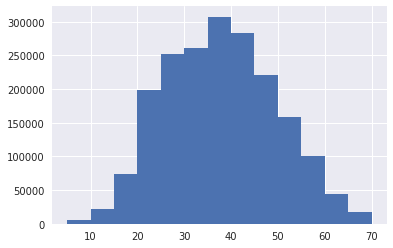

In [27]:
plot.hist(data.userAge.astype('int'), bins = range(5,75,5))

In [28]:
# remove rows with null values
data.dropna(axis=0, inplace=True)
# remove rows where userAge=5 or userAge>=70
data = data[(data.userAge>=5) & (data.userAge<70)]

data = data.drop(['visitId','VisitingHour','VisitingDayOfWeek'],axis=1)

# prepare column browser, change browers that are not specified below to 'other'
data.loc[(data.browser != 'Chrome') &
         (data.browser != 'Safari') &
         (data.browser != 'Firefox') &
         (data.browser != 'Samsung Internet') &
         (data.browser != 'Android Webview') &
         (data.browser != 'Edge') &
         (data.browser !='Internet Explorer'),'browser'] = 'other'

# prepare column language
data.rename(columns = {'LANGUAGE':'language'}, inplace=True)
data.loc[data.language.str.contains('en'),'language'] = 'en'  #data has inconsistent values e.g. 'en','en-en','en-bg'
data.loc[data.language.str.contains('th'),'language'] = 'th'
data.language.str.contains('en|th')
data.loc[(data.language!='th') & 
         (data.language!='en'),'language'] = 'other'

# prepare column operatingSystem
data.loc[(data.operatingSystem != 'Windows') &
         (data.operatingSystem != 'Android') &
         (data.operatingSystem != 'Macintosh') &
         (data.operatingSystem !='iOS'),'operatingSystem'] = 'other'

# prepare column source 
data.loc[data.source.str.contains('facebook'),'source'] = 'facebook' #data has inconsistent value such as 'facebook','facebook.com'
data.loc[data.source.str.contains('google'),'source'] = 'google'
data.loc[data.source.str.contains('sanook'),'source'] = 'sanook'
data.loc[data.source.str.contains('direct'),'source'] = 'direct'
data.loc[(data.source != 'facebook') &
         (data.source != 'google') &
         (data.source != 'sanook') &
         (data.source !='direct'),'source'] = 'other'

# remove rows where contentCategory contains non-english characters
data = data[data.contentCategory.str.contains('^[A-Za-z]+$', regex=True)]
data.loc[:,'contentCategory'] = data.contentCategory.str.lower()
print(data.shape)

(1322317, 8)


In [29]:
def make_pivot_table(columns):
    result =None
    for column in columns:
        pivot = data.loc[:,['fullVisitorId',column]]
        pivot = pivot.pivot_table(index='fullVisitorId',columns=column,aggfunc= any)
        pivot.columns = ['_'.join((column,i)) for i  in pivot.columns]
        if result is None:
          result = pivot
        else:
          result = result.join(pivot)
        
    result = result.replace({
      True:1,
      None:0
    })
    return result

age = data.loc[:,['fullVisitorId','userAge']].drop_duplicates().set_index('fullVisitorId')    
data = make_pivot_table(data.columns[1:-1])
data = data.join(age)

In [30]:
#remove columns with less than 0.1% of 1s  
#data = data[data.columns[data.sum()>data.shape[0]*0.001]]


In [31]:
############## without bins  #################

train_dataset = data.sample(frac=0.8,random_state=0).astype('float64')   #############
test_dataset = data.drop(train_dataset.index).astype('float64')

train_labels = train_dataset['userAge']
train_dataset = train_dataset.drop('userAge',axis = 1)
test_labels = test_dataset['userAge']
test_dataset = test_dataset.drop('userAge',axis = 1)

#covnert dataframe to ndarrays for tensorflow input 
train_dataset = train_dataset.values
train_labels = train_labels.values
test_dataset = test_dataset.values
test_labels = test_labels.values

In [32]:
  # regression, for age before binning 
    
model1 = keras.Sequential([
    keras.layers.Dense(16,activation = tf.nn.relu, input_shape = (train_dataset.shape[1],) ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16,activation = tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)   
  ])
  
  
model1.compile(loss= 'mse',  # mean square error
               optimizer = tf.train.RMSPropOptimizer(0.001),
               metrics=['mae'])
# automatically stop epochs when val_loss stops decreasing
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience =20)
history1 = model1.fit(train_dataset,train_labels, epochs = 20, batch_size = 1000,validation_split = 0.2, verbose=1, 
                              callbacks = [early_stop])



Train on 351879 samples, validate on 87970 samples
Epoch 1/20
351879/351879 [==============================] - 5s 14us/step - loss: 888.0961 - mean_absolute_error: 26.0179 - val_loss: 194.4606 - val_mean_absolute_error: 10.9435
Epoch 2/20
351879/351879 [==============================] - 4s 13us/step - loss: 351.8316 - mean_absolute_error: 15.0190 - val_loss: 170.5161 - val_mean_absolute_error: 10.3115
Epoch 3/20
351879/351879 [==============================] - 4s 13us/step - loss: 310.0323 - mean_absolute_error: 14.0717 - val_loss: 160.7524 - val_mean_absolute_error: 10.0390
Epoch 4/20
351879/351879 [==============================] - 5s 13us/step - loss: 290.0208 - mean_absolute_error: 13.5945 - val_loss: 155.7924 - val_mean_absolute_error: 9.9049
Epoch 5/20
351879/351879 [==============================] - 4s 13us/step - loss: 272.0067 - mean_absolute_error: 13.1473 - val_loss: 155.9910 - val_mean_absolute_error: 9.9088
Epoch 6/20
351879/351879 [==============================] - 4s 13u

In [33]:
model2 = keras.Sequential([
    keras.layers.Dense(256,activation = tf.nn.relu, input_shape = (train_dataset.shape[1],) ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation = tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)   
  ])
  
  
model2.compile(loss= 'mse',  # mean square error
               optimizer = tf.train.RMSPropOptimizer(0.001),
               metrics=['mae'])
# automatically stop epochs when val_loss stops decreasing
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience =20)
history2 = model2.fit(train_dataset,train_labels, epochs = 20, batch_size = 1000,validation_split = 0.2, verbose=1, 
                              callbacks = [early_stop])


Train on 351879 samples, validate on 87970 samples
Epoch 1/20
351879/351879 [==============================] - 13s 38us/step - loss: 240.4831 - mean_absolute_error: 12.0245 - val_loss: 134.9318 - val_mean_absolute_error: 9.4804
Epoch 2/20
351879/351879 [==============================] - 13s 37us/step - loss: 156.5786 - mean_absolute_error: 10.1146 - val_loss: 134.1996 - val_mean_absolute_error: 9.4408
Epoch 3/20
351879/351879 [==============================] - 13s 36us/step - loss: 155.3660 - mean_absolute_error: 10.0807 - val_loss: 137.2544 - val_mean_absolute_error: 9.4551
Epoch 4/20
351879/351879 [==============================] - 12s 35us/step - loss: 154.4504 - mean_absolute_error: 10.0417 - val_loss: 133.6390 - val_mean_absolute_error: 9.4617
Epoch 5/20
351879/351879 [==============================] - 13s 36us/step - loss: 153.9598 - mean_absolute_error: 10.0273 - val_loss: 135.6092 - val_mean_absolute_error: 9.4168
Epoch 6/20
351879/351879 [==============================] - 13s 

Text(0.5,1,'comparison of different models')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


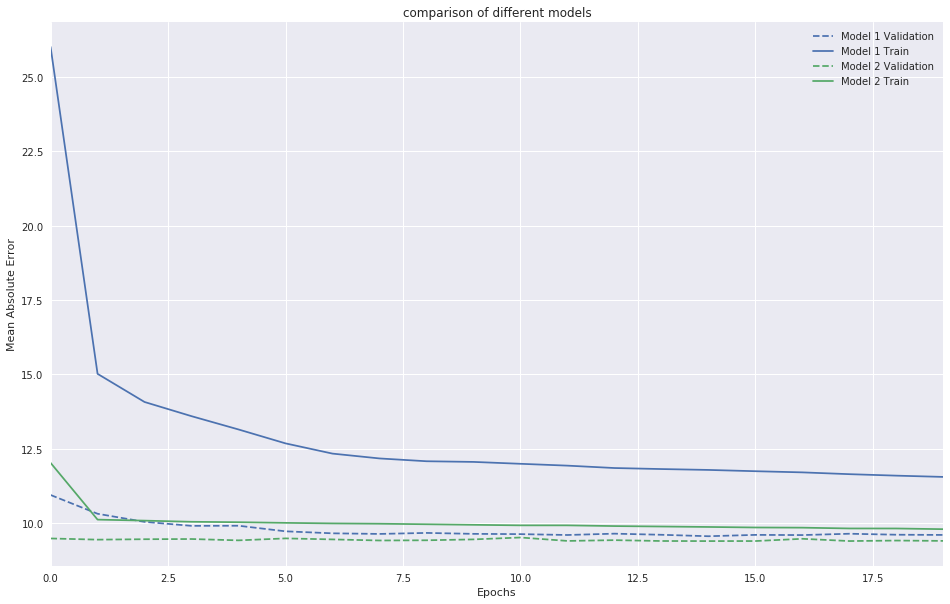

In [34]:
def plot_history(histories, key='mean_absolute_error'):
  plot.figure(figsize=(16,10))
  for name, history in histories:
    val = plot.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Validation')
    plot.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plot.xlabel('Epochs')
  plot.ylabel(key.replace('_',' ').title())
  plot.legend()
  plot.xlim([0,max(history.epoch)])
  
  
plot_history([('model 1',history1),('model 2',history2)])
plot.title('comparison of different models')

Text(0.5,1,'actual vs prediction')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


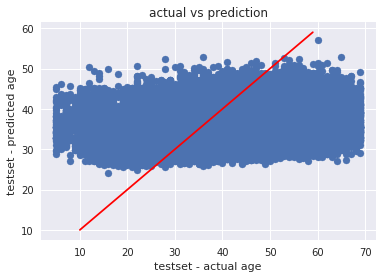

In [35]:
test_predictions = model2.predict(test_dataset)
plot.scatter(test_labels, test_predictions)
plot.plot(range(10,60), range(10,60), 'r')
plot.xlabel('testset - actual age')
plot.ylabel('testset - predicted age')
plot.title('actual vs prediction')


In [36]:
############## data with age binned ##############
# put age into different bins, 5 years per bin, from 5 to 70, total 13 bins 
# [5-10) => 0
# [10-15) => 1
# [65-70) => 12
data['userAgeBins'] = ((1+data.userAge)/5 ).apply(math.ceil)-2

data.drop('userAge',axis =1)
train_dataset_bin = data.sample(frac=0.8,random_state=0).astype('float64')   #############
test_dataset_bin = data.drop(train_dataset_bin.index).astype('float64')

train_labels_bin = train_dataset_bin['userAgeBins']
train_dataset_bin = train_dataset_bin.drop('userAgeBins',axis = 1)
test_labels_bin = test_dataset_bin['userAgeBins']
test_dataset_bin = test_dataset_bin.drop('userAgeBins',axis = 1)

#covnert dataframe to ndarrays for tensorflow input 
train_dataset_bin = train_dataset_bin.values
train_labels_bin = train_labels_bin.values
test_dataset_bin = test_dataset_bin.values
test_labels_bin = test_labels_bin.values

(array([ 1544.,  8814., 27286., 67664., 83102., 76267., 79420., 69845.,
        54209., 38923., 26038., 12318.,  4381.]),
 array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
 <a list of 13 Patch objects>)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


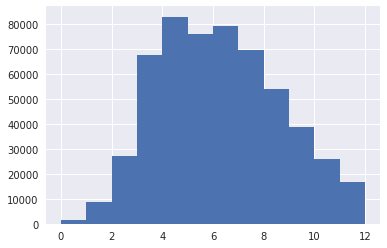

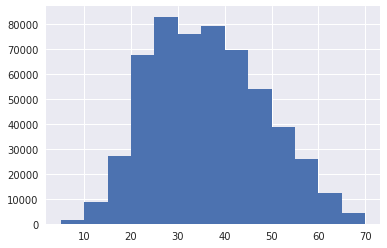

In [37]:
plot.figure()
plot.hist(data.userAgeBins, bins = range(0,13))
plot.figure()
plot.hist(data.userAge.astype('int'), bins = range(5,75,5))

In [38]:
model_bin = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape = (train_dataset_bin.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(13, activation=tf.nn.softmax)
])

model_bin.compile(optimizer=tf.train.AdamOptimizer(), 
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_bin = model_bin.fit(train_dataset_bin,train_labels_bin, epochs =30, batch_size = 1000 ,validation_split=0.1, verbose=0)
results = model_bin.evaluate(test_dataset_bin, test_labels_bin)
print(results)

108928/108928 [==============================] - 3s 31us/step
[0.008101477306280077, 0.9995042596944771]


Text(0.5,1,'accuracy for the model with user age binned')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


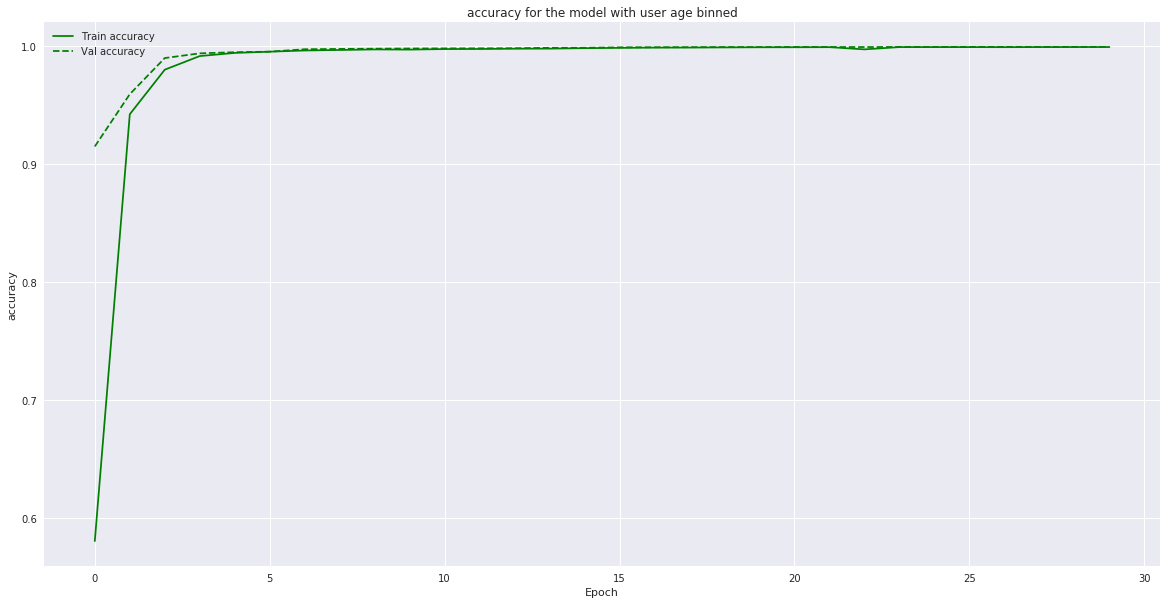

In [39]:
plot.figure(figsize = (20,10))
plot.xlabel('Epoch')
plot.ylabel('accuracy')
plot.plot(history_bin.epoch, history_bin.history['acc'],'g',label='Train accuracy')
plot.plot(history_bin.epoch, history_bin.history['val_acc'], 'g--',label='Val accuracy')
plot.legend()
plot.title('accuracy for the model with user age binned')

In [40]:

test_predictions_bin = model_bin.predict(test_dataset_bin)
test_predictions_bin = pd.DataFrame(test_predictions_bin).apply(np.argmax, axis =1)


/usr/local/envs/py3env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'test data')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


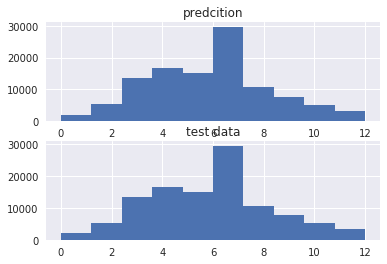

In [41]:
plot.subplot(2,1,1)
plot.hist(test_predictions_bin)
plot.title('predcition')

plot.subplot(2,1,2)
plot.hist(test_labels_bin)
plot.title('test data')

([<matplotlib.axis.YTick at 0x7fbcfbc490f0>,
 <a list of 13 Text yticklabel objects>)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


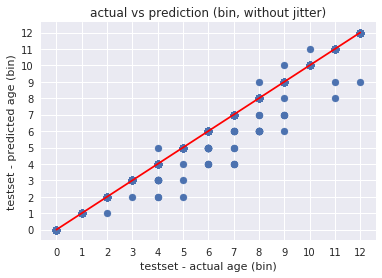

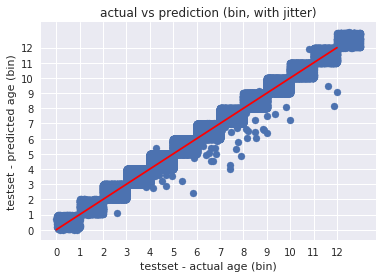

In [42]:
# without jitter, lots of overlap 
plot.figure()
plot.scatter(test_labels_bin, test_predictions_bin)
plot.plot(range(0,13), range(0,13), 'r')
plot.xlabel('testset - actual age (bin)')
plot.ylabel('testset - predicted age (bin)')
plot.title('actual vs prediction (bin, without jitter)')
plot.xticks(np.arange(0,13,1))
plot.yticks(np.arange(0,13,1))


# manually add jitter 
plot.figure()
test_labels_bin_jitter = test_labels_bin + np.random.rand(test_labels_bin.shape[0])
test_predictions_bin_jitter = test_predictions_bin + np.random.rand(test_predictions_bin.shape[0])
plot.scatter(test_labels_bin_jitter, test_predictions_bin_jitter)
plot.plot(range(0,13), range(0,13), 'r')
plot.xlabel('testset - actual age (bin)')
plot.ylabel('testset - predicted age (bin)')
plot.title('actual vs prediction (bin, with jitter)')
plot.xticks(np.arange(0,13,1))
plot.yticks(np.arange(0,13,1))